# Quantum Counting Using the Iterative Quantum Amplitude Estimation Algorithm

The quantum counting algorithm [[1](#QCWiki)] efficiently estimates the number of valid solutions to a search problem, based on the amplitude estimation algorithm. It demonstrates a quadratic improvement with regard to a classical algorithm with black box oracle access to the function $f$.

More precisely, given a Boolean function $f :\{0, 1\}^n\rightarrow\{0,1\}$, the counting problem estimates the number of inputs $x$ to $f$ such that $f(x)=1$.

This tutorial demonstrates how to estimate the counting problem using a specific variant of the amplitude estimation algorithm: the Iterative Quantum Amplitude Estimation (IQAE) [[2](#IQAE)].

The IQAE does not rely on the Quantum Phase Estimation algorithm [[3](#AE)], but purely on applications of the grover operator:
$$
Q\equiv -  A S_0 A^{\dagger} S_{\psi_1},
$$
thereby reducing the required number of qubits and gates of the circuit, at the expense of additional multiplicative factor polylogarithmic in the error $\epsilon$.


## Setting Up the Problem

We choose this equation:
$$
(a + b) <= 2
$$
where $a$, $b$ are 2-bit unsigned integers. This equation has six solutions. The goal is to estimate the number of valid solutions out of the 16 possible inputs, with precision $0.5$.




## Amplitude Estimation Using Phase Estimation

We first show how to use quantum phase estimation algorithm for quantum counting [[3](#AE)], then solve it using the IQAE method.

Given a state $|\psi\rangle$ such that $|\psi\rangle=\sqrt{a}|\psi_1\rangle+\sqrt{1-a}|\psi_0\rangle$ we can measure $a$ up to arbitrary precision, given the following building blocks:
1) State preparation: 
A unitary $A$ such that: $A|0\rangle = |\psi\rangle = \sqrt{a}|\psi_1\rangle+\sqrt{1-a}|\psi_0\rangle$.


2) Oracle:
A unitary $S_{\psi_1}$ such that $S_{\psi_1}=I-2|\psi_1\rangle\langle\psi_1|$, which adds a $(-1)$ phase to $|\psi_1|\psi\rangle\rangle$ and does nothing to any orthognal states to $|\psi_1\rangle$.
This is effectively a reflection around the "good" state $|\psi_1\rangle$.

Given these two functions, we can construct the Grover operator:
$$
Q\equiv -  A S_0 A^{\dagger} S_{\psi_1} ,
$$
which is exactly the same operator as for the Grover's search algorithm. 


In the subspace spanned by $|\psi_1\rangle$ and $|\psi_0\rangle$, $Q$ has two eigenvalues: 
$$
\lambda_{\pm}=\exp\left(\pm i2\pi \theta \right), \qquad \sin^2 \left(\pi \theta\right)\equiv a.
$$

Therefore, if we apply a QPE on $A|0\rangle$ we have these two eigenvalues encoded in the QPE register; however, both give the value of $a$, so there is no ambiguity.

### Arithmetic Oracle

We define the $S_{\psi_1}$ oracle:

$$
S_{\psi_1}|a\rangle|b\rangle= (-1)^{f(a,b)}|a\rangle|b\rangle.
$$

In [1]:
from classiq import *

A_SIZE = 2
B_SIZE = 2
DOMAIN_SIZE = A_SIZE + B_SIZE


class OracleVars(QStruct):
    a: QNum[A_SIZE]
    b: QNum[B_SIZE]


@qperm
def arith_equation(state: Const[OracleVars], res: QBit):
    res ^= state.a + state.b <= 2


# use phase kickback for turning the arith_equation to an oracle
@qfunc
def arith_oracle(state: OracleVars):
    phase_oracle(arith_equation, state)

### State Preparation Oracle

The state preparation function $A$ reflects knowledge about the solution space and can be used to eliminate invalid assignments. Here we assume no knowledge of the solution space; hence, we use the uniform superposition state preparation.

In [5]:
sp_oracle = hadamard_transform

### Wrapping All to the Phase Estimation

We will achieve the desired precision only in the IQAE phase. Here, we compute the worst-case precision for five phase qubits:

In [6]:
import numpy as np

NUM_PHASE_QUBITS = 5

x = np.linspace(0, 1, 100)
(2**DOMAIN_SIZE) * max(
    np.abs(
        np.sin(np.pi * x) ** 2 - np.sin(np.pi * (x - 1 / (2**NUM_PHASE_QUBITS))) ** 2
    )
)

1.5681439279637486

We use the `grover_operator` library function, where we plug in the defined oracles. We wrap it by the `qpe` function, that accepts the grover operator as a unitary, and additional `phase` register.

In [7]:
@qfunc
def main(
    phase_reg: Output[QNum[NUM_PHASE_QUBITS, UNSIGNED, NUM_PHASE_QUBITS]],
) -> None:
    state_reg = OracleVars()
    allocate(state_reg)
    allocate(phase_reg)

    sp_oracle(state_reg)
    qpe(
        unitary=lambda: grover_operator(
            arith_oracle,
            sp_oracle,
            state_reg,
        ),
        phase=phase_reg,
    )
    drop(state_reg)

### Synthesizing the Model to a Quantum Program

In [8]:
constraints = Constraints(max_width=14)
qmod_qpe = create_model(
    main,
    constraints=constraints,
    preferences=Preferences(optimization_level=1),
    out_file="quantum_counting_qpe",
)
qprog_qpe = synthesize(qmod_qpe)
show(qprog_qpe)

Quantum program link: https://platform.classiq.io/circuit/32pSFY9VF2TayfnH2DMe7YFeGcl


### Executing the Quantum Program

In [9]:
result = execute(qprog_qpe).result_value()

Upon plotting the resulting histogram, we see two phase values with high probability (however, both correspond to the same amplitude). Note that `phase_reg` is already coded as fixed QNum in the range [0,1].

phase with max probability:  0.78125


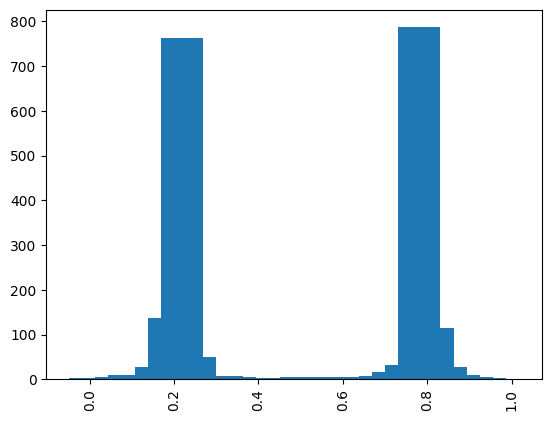

In [10]:
import matplotlib.pyplot as plt

phases_counts = dict(
    (sampled_state.state["phase_reg"], sampled_state.shots)
    for sampled_state in result.parsed_counts
)
plt.bar(phases_counts.keys(), phases_counts.values(), width=0.1)
plt.xticks(rotation=90)
print("phase with max probability: ", max(phases_counts, key=phases_counts.get))

From the phase, we can extract the number of solutions:

In [11]:
expected_num_solutions = 6
solutions_ratio_qpe = np.sin(np.pi * max(phases_counts, key=phases_counts.get)) ** 2
print(
    "Number of solutions: ",
    (2**DOMAIN_SIZE) * solutions_ratio_qpe,
)
assert np.isclose(
    (2**DOMAIN_SIZE) * solutions_ratio_qpe, expected_num_solutions, atol=1.5
)

Number of solutions:  6.439277423870974


## Amplitude Estimation Using Iterative Quantum Amplitude Estimation

Now we are ready for the iterative method. 

Instead of QPE, the algorithm applies the unitary
$$
(Q)^mA
$$
where $m$, the number of repetitions, changes between iterations of the algorithm.

There is one subtlety that changes the way we work with the Grover operator. The classical algorithm expects an additional indicator qubit that marks the "good" states, i.e.:
$$
|a\rangle|b\rangle|f(a,b)\rangle
$$

So now, most of our logic goes into the state preparation oracle ($A$). It combines the loading of the solution space with setting the indicator qubit.

In [12]:
@qfunc
def iqae_state_preparation(vars: OracleVars, ind: QBit):
    hadamard_transform(vars)
    arith_equation(vars, ind)

### Wrapping All to the Iterative Quantum Amplitude Estimation Algorithm

We use the built-in `IQAE` class that the quantum code for the algorithm as well as the classical execution code. The circuit starts with the state $A|0\rangle$, then applies iterations of the Grover operator. 

Note that the algorithm applies a varied number of Grover iterations on each execution. The number of iterations is chosen dynamically based on previous execution results, using statistical inference methods. It expects a state preparation function that creates the following state:
$$
|\Psi\rangle = a|\Psi_1\rangle|1\rangle_{ind} + \sqrt{1-a^2}|\Psi_0\rangle|0\rangle_{ind}
$$
Where the indicator qubit is marking the wanted state.

In [13]:
from classiq.applications.iqae.iqae import IQAE

iqae = IQAE(
    state_prep_op=iqae_state_preparation,
    problem_vars_size=DOMAIN_SIZE,
    constraints=Constraints(optimization_parameter="width"),
    preferences=Preferences(optimization_level=1),
)

### Synthesizing the Model to a Quantum Program

In [14]:
qmod = iqae.get_model()
write_qmod(qmod, "quantum_counting_iqae", decimal_precision=10)

qprog_iqae = iqae.get_qprog()
show(qprog_iqae)

Quantum program link: https://platform.classiq.io/circuit/32pSIs3apHDldfDrbzHHHCWW7UY


### Executing the Quantum Program

In [15]:
iqae_result = iqae.run(
    epsilon=1 / (2**DOMAIN_SIZE * 2),
    alpha=0.01,  # desired error  # desired probability for error
)

We set $\epsilon = 1/{2^4} \cdot 0.5 = 1/32$. `alpha` is the tail probability of estimating the result with accuracy $\epsilon$.

In [16]:
print(
    f"Number of solutions: {(2**DOMAIN_SIZE) * iqae_result.estimation}, accuracy: "
    f"{(2**DOMAIN_SIZE)*(iqae_result.confidence_interval[1]-iqae_result.confidence_interval[0])}"
)

Number of solutions: 6.011647242198923, accuracy: 0.09716976875854222


In [17]:
assert np.isclose(
    (2**DOMAIN_SIZE) * iqae_result.estimation, 6, atol=1 / (2**DOMAIN_SIZE - 1)
)

We can also see the statistics of the IQAE execution:

In [18]:
for i, iteration in enumerate(iqae_result.iterations_data):
    print(
        f"iteration_id: {i}, num grover iterations: {iteration.grover_iterations}, counts: {iteration.sample_results.counts}"
    )

iteration_id: 0, num grover iterations: 0, counts: {'0': 1268, '1': 780}
iteration_id: 1, num grover iterations: 6, counts: {'0': 898, '1': 1150}


## References

<a name='QCWiki'>[1]</a>: [Quantum Counting Algorithm, Wikipedia](https://en.wikipedia.org/wiki/Quantum_counting_algorithm).

<a name='IQAE'>[2]</a>: [Grinko, D., Gacon, J., Zoufal, C. et al. Iterative quantum amplitude estimation. npj Quantum Inf 7, 52 (2021)](https://doi.org/10.1038/s41534-021-00379-1).

<a name='AE'>[3]</a>: [Brassard, G., Hoyer, P., Mosca, M., & Tapp, A. (2002). Quantum Amplitude Amplification and Estimation. Contemporary Mathematics, 305, 53-74.](https://arxiv.org/abs/quant-ph/0005055)
